In [5]:
import numpy as np
from scipy.spatial import KDTree
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd


def preprocess_cores(cores):
    """
    Preprocess the core data to normalize positions, inverting the y-axis so that
    the numbering starts from the top left corner.
    :param cores: List of dictionaries with 'x', 'y', and 'radius' keys.
    :return: Normalized list of core coordinates with the y-axis inverted.
    """
    # Extract coordinates
    coordinates = np.array([(core['x'], core['y']) for core in cores])

    # Normalize coordinates (shift to origin) and invert y-axis
    min_x, max_y = np.min(coordinates[:, 0]), np.max(coordinates[:, 1])
    normalized_inverted_coordinates = np.array(
        [(x - min_x, max_y - y) for x, y in coordinates]
    )

    return normalized_inverted_coordinates


def estimate_grid(normalized_coordinates):
    """
    Estimate the grid pattern based on normalized core coordinates.
    :param normalized_coordinates: Array of normalized core coordinates.
    :return: Estimated row and column deltas.
    """
    # Compute pairwise distances
    kdtree = KDTree(normalized_coordinates)
    # Query the nearest two points for each point
    distances, _ = kdtree.query(normalized_coordinates, k=4)

    # Estimate grid spacing
    # Average distance to the nearest neighbor
    avg_distance = np.median(distances[:, 1])
    return avg_distance

def get_row_col(coord, grid_spacing):
    """
    Extract the row and column from a coordinate.
    :param coord: The coordinate (x, y).
    :param grid_spacing: The grid spacing.
    :return: Tuple of (row, column).
    """
    row = int(round(coord[1] / grid_spacing))
    col = int(round(coord[0] / grid_spacing))
    return row, col


def assign_to_grid(normalized_coordinates, grid_spacing):
    """
    Assign each core to a grid position based on estimated grid spacing, considering
    the inverted y-axis. Also, adjust assignments for neighbor consistency.
    :param normalized_coordinates: Array of normalized core coordinates.
    :param grid_spacing: Estimated grid spacing (average distance between cores).
    :param threshold_distance: Distance threshold for considering neighbors.
    :return: Dictionary of core positions with row and column assignments.
    """
    # Initialize dictionary of core positions with row and column assignments.
    grid_positions = defaultdict(list)

    # First pass: initial assignment
    for idx, coord in enumerate(normalized_coordinates):
        # Get row and column for each core coordinate
        row, col = get_row_col(coord, grid_spacing)
        # Append index of core coordinate to corresponding row and column.
        grid_positions[(row, col)].append(idx)


    return grid_positions


# Main workflow
data = pd.read_json('./TMA_WSI_Labels_updated/ABC_104_1_009_1.json')
data = data.to_dict('records')

# Apply the transformation to all core coordinates
normalized_coordinates = preprocess_cores(data)

# grid_spacing = estimate_grid(transformed_coordinates)
grid_spacing = estimate_grid(normalized_coordinates)
grid_positions = assign_to_grid(normalized_coordinates, grid_spacing)

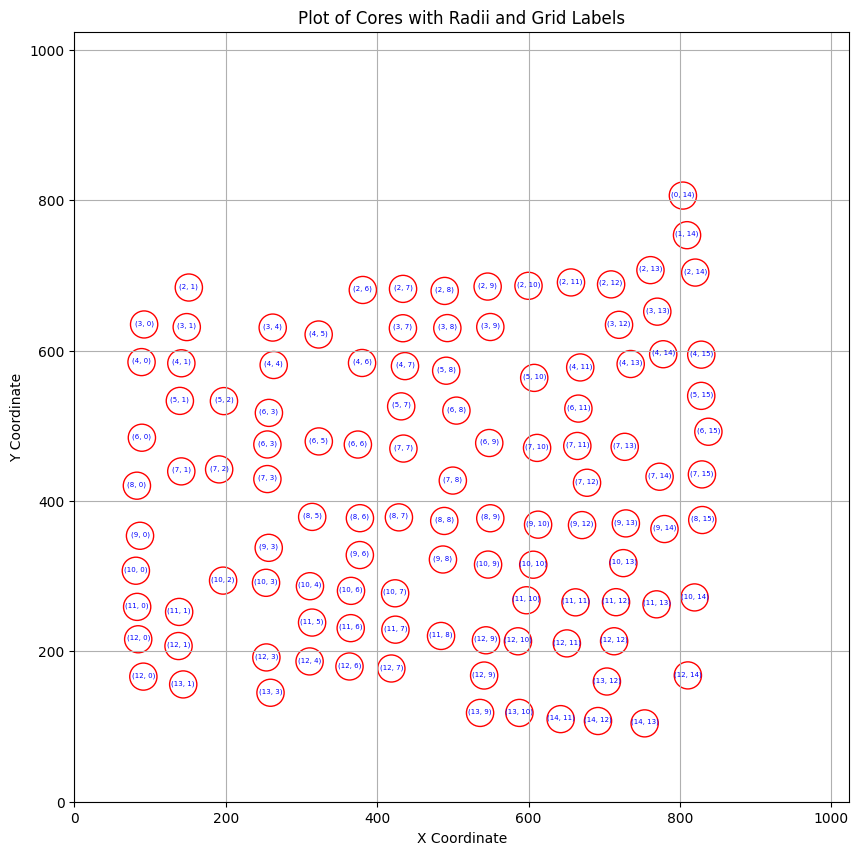

In [7]:
# Now we will attempt the plotting again, making sure to access the dictionary correctly
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# Plot each core with its radius and label
for idx, core in enumerate(data):
    # Draw the core as a circle
    circle = plt.Circle((core['x'], core['y']), radius=core['radius'], edgecolor='r', facecolor='none')
    ax.add_patch(circle)

    # Get grid position for the label
    grid_label = None
    for pos, indices in grid_positions.items():
        if idx in indices:
            grid_label = pos
            break
    
    # Only label the core if we found a grid position
    if grid_label is not None:
        ax.text(core['x'], core['y'], str(grid_label), color='blue', fontsize=5, ha='center')

# Set the limits of the plot to the size of the image
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])

# Add grid, legend, and labels
ax.grid(True)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Plot of Cores with Radii and Grid Labels')

# Show the plot
plt.show()